In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3, Xception, MobileNet, NASNetLarge, ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

import tensorflow as tf
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [2]:
imagePaths = list(paths.list_images("NIH"))
data = []
labels = []

In [3]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
# imagePaths = list(paths.list_images(args["dataset"]))
# data = []
# labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread(imagePath)
#	cv2.imshow('image',image)
#	cv2.waitKey(4)
#	cv2.destroyAllWindows()
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (128, 128))

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

[INFO] loading images...


In [5]:
cv2.imshow('image',data[10])
cv2.waitKey(4)
cv2.destroyAllWindows()

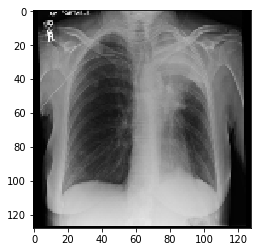

In [48]:
plt.imshow(data[1])
plt.show()

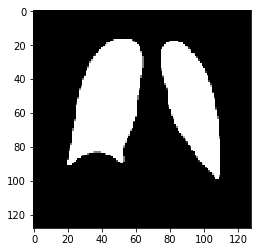

In [49]:
plt.imshow(data[101])
plt.show()

In [39]:
images = data[0:100]
masks = data[100:]
import pandas as pd

# holding 80 of the images for train
# X_train = images[0:81]
# y_train = masks[0:81]

# holding 20 of the images for test
# X_test = images[81:100]
# y_test = masks[81:]

In [40]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [32]:
X_train = np.zeros((len(data), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

print('Resizing training images')
for n in range(81):
    img = data[n]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img

Resizing training images


In [87]:
# y_train = np.zeros((len(data), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
# y_train = np.zeros((len(data), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

y_train = np.zeros((len(data), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

print('Resizing training masks')
for n in range(81):
    n = n + 100
    img = data[n]
#    img.shape
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#    img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True), axis=-1)
    y_train[n] = img  #Fill empty X_train with values from img

Resizing training masks


In [136]:
#Build the model
inputs = tf.keras.layers.Input((200,128,128,3))
inputs = tf.reshape(inputs,shape=(200,128,128,3))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

In [139]:
s.shape

TensorShape([200, 128, 128, 3])

In [140]:
#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)


In [ ]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

In [91]:
################################
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [92]:
results = model.fit(X_train, y_train, validation_split=0.1, epochs=25, callbacks=callbacks)

ValueError: A target array with shape (200, 128, 128, 3) was passed for an output of shape (None, 128, 128, 1) while using as loss `binary_crossentropy`. This loss expects targets to have the same shape as the output.

In [33]:
################################
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

####################################

idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()


In [37]:
display(Image.open(data[10]))

AttributeError: 'numpy.ndarray' object has no attribute 'read'

In [160]:
%matplotlib inline
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import matplotlib.pyplot as plt
USE_CV2 = True
if USE_CV2:
    from cv2 import imread # opencv is much faster, but less accurate
    MIN_OBJ_VAL = 0
else:
    from skimage.io import imread
    MIN_OBJ_VAL = 1000

from skimage.segmentation import mark_boundaries
DATA_DIR = os.path.join('..', 'NIH/')

In [161]:
DATA_DIR

'../NIH/'

In [221]:
all_paths = pd.DataFrame(imagePaths).rename(columns={0:'path'})

In [222]:
all_paths['split'] = all_paths['path'].map(lambda x: x.split('/')[-2].split('_')[0])

In [223]:
all_paths['group'] = all_paths['path'].map(lambda x: x.split('/')[-2].split('_')[-1])

In [224]:
all_paths['group'] = all_paths['group'].map(lambda x: 'color' if x == 'test' else x)

In [225]:
all_paths['id'] = all_paths['path'].map(lambda x: '_'.join(os.path.splitext(os.path.basename(x))[0].split('_')[:4]))
all_paths.sample(5)

,path,split,group,id
196,NIH/masks/NIH_0014_mask.png,masks,masks,NIH_0014_mask
191,NIH/masks/NIH_0021_mask.png,masks,masks,NIH_0021_mask
85,NIH/images/NIH_0020.png,images,images,NIH_0020
72,NIH/images/NIH_0079.png,images,images,NIH_0079
79,NIH/images/NIH_0087.png,images,images,NIH_0087


In [226]:
group_df = all_paths.pivot_table(values = 'path', columns = 'group', aggfunc = 'first', index = ['id', 'split']).reset_index()
group_df.sample(5)

group,id,split,images,masks
91,NIH_0046_mask,masks,NaN,NIH/masks/NIH_0046_mask.png
46,NIH_0024,images,NIH/images/NIH_0024.png,NaN
28,NIH_0015,images,NIH/images/NIH_0015.png,NaN
113,NIH_0057_mask,masks,NaN,NIH/masks/NIH_0057_mask.png
49,NIH_0025_mask,masks,NaN,NIH/masks/NIH_0025_mask.png


In [227]:
group_df_image = group_df[group_df['split']=='images'].head(60)
group_df_masks = group_df[group_df['split']=='masks'].head(60)

In [228]:
train_df = pd.concat([group_df_image,group_df_masks],ignore_index=True)

In [229]:
train_df = train_df.rename(columns={'masks':'masks_'})
train_df = train_df.rename(columns={'images':'images_'})

In [230]:
train_df = train_df.replace('masks','train')

In [231]:
train_df = train_df.replace('images','train')

In [232]:
# train_df = group_df.query('split=="train"')
print(train_df.shape[0], 'rows')
sample_rows = 6

120 rows


In [235]:
train_df.head()

group,id,split,images_,masks_
0,NIH_0001,train,NIH/images/NIH_0001.png,NaN
1,NIH_0002,train,NIH/images/NIH_0002.png,NaN
2,NIH_0003,train,NIH/images/NIH_0003.png,NaN
3,NIH_0004,train,NIH/images/NIH_0004.png,NaN
4,NIH_0005,train,NIH/images/NIH_0005.png,NaN


In [239]:
from sklearn.model_selection import train_test_split
train_split_df, valid_split_df = train_test_split(train_df, random_state = 2018, test_size = 0.25)

In [240]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input
IMG_SIZE = (384, 384) # slightly smaller than vgg16 normally expects
img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05)

rgb_gen = ImageDataGenerator(preprocessing_function = preprocess_input, **img_gen_args)
lab_gen = ImageDataGenerator(**img_gen_args)

Using TensorFlow backend.


In [241]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, seed = None, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways: seed: {}'.format(seed))
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                              seed = seed,
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [242]:
import keras.preprocessing.image as KPImage
from PIL import Image
class pil_image_awesome():
    @staticmethod
    def open(in_path):
        if 'instanceIds' in in_path:
            # we only want to keep the positive labels not the background
            in_img = imread(in_path)
            if in_img.ndim==3:
                in_img = in_img[:,:,0]
            return Image.fromarray((in_img>MIN_OBJ_VAL).astype(np.float32))
        else:
            return Image.open(in_path)
    
    fromarray = Image.fromarray

KPImage.pil_image = pil_image_awesome

In [243]:
from skimage.filters.rank import maximum
from scipy.ndimage import zoom
def lab_read_func(in_path):
    bin_img = (imread(in_path)>1000).astype(np.uint8)
    x_dim, y_dim = bin_img.shape
    max_label_img = maximum(bin_img, np.ones((x_dim//IMG_SIZE[0], y_dim//IMG_SIZE[1])))
    return np.expand_dims(zoom(max_label_img, (IMG_SIZE[0]/x_dim, IMG_SIZE[1]/y_dim), order = 3), -1)

In [256]:
def train_and_lab_gen_func(in_df, batch_size = 8, seed = None):
    if seed is None:
        seed = np.random.choice(range(1000))
    train_rgb_gen = flow_from_dataframe(rgb_gen, in_df, 
                             path_col = 'images_',
                            y_col = 'id', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = batch_size,
                                   seed = seed)
    train_lab_gen = flow_from_dataframe(lab_gen, in_df, 
                             path_col = 'masks_',
                            y_col = 'id', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = batch_size,
                                   seed = seed)
    for (x, _), (y, _) in zip(train_rgb_gen, train_lab_gen):
        yield x, y

In [257]:
train_and_lab_gen = train_and_lab_gen_func(train_split_df, batch_size = 32)

In [258]:
valid_and_lab_gen = train_and_lab_gen_func(valid_split_df, batch_size = 32)

In [259]:
(rgb_batch, lab_batch) = next(valid_and_lab_gen)

## Ignore next message from keras, values are replaced anyways: seed: 564
Found 0 images belonging to 0 classes.
Reinserting dataframe: 30 images


TypeError: expected str, bytes or os.PathLike object, not float

In [250]:
(rgb_batch, lab_batch) = next(valid_and_lab_gen)

sample_rows = 4
fig, m_axs = plt.subplots(sample_rows, 3, figsize = (20, 6*sample_rows))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2, ax3), rgb_img, lab_img in zip(m_axs, rgb_batch, lab_batch):
    # undoing the vgg correction is tedious
    r_rgb_img = np.clip(rgb_img+110, 0, 255).astype(np.uint8)
    ax1.imshow(r_rgb_img)
    ax1.set_title('Color')
    ax2.imshow(lab_img[:,:,0], cmap = 'nipy_spectral')
    ax2.set_title('Labels')
    if lab_img.max()>0.1:
        xd, yd = np.where(lab_img[:,:,0]>0)
        bound_img = mark_boundaries(image = r_rgb_img, label_img = lab_img[:,:,0], 
                                    color = (1,0,0), background_label = 255, mode = 'thick')
        ax3.imshow(bound_img[xd.min():xd.max(), yd.min():yd.max(),:])
        ax3.set_title('Cropped Overlay')

KeyError: 'color'